# Running on AWS

*Author: Creare* <br>
*Date: April 01 2020* <br>

**Keywords**: processing, cloud, AWS

## Overview

Runing PODPAC Pipeline on AWS Lambda.

### Prerequisites

- Python 2.7 or above
- [`podpac[datatype]`](https://podpac.org/install.html#install)
- [`podpac[aws]`](https://podpac.org/install.html#install)
- *Review the [README.md](../../README.md) and [jupyter-tutorial.ipynb](../jupyter-tutorial.ipynb) for additional info on using jupyter notebooks*


### See Also

- [AWS Lambda Tutorial](../4-advanced/aws-lambda.ipynb): Tutorial for **setting up the PODPAC Lambda function on AWS**
- [AWS Budgeting Tutorial](../4-advanced/aws-budget.ipynb): Tutorial for budgeting with PODPAC and AWS
- [SMAP Datalib](../5-datalib/smap/010-retrieving-SMAP-data.ipynb): SMAP Datalib tutorial
- [100-analyzing-SMAP-data.ipynb](../5-datalib/smap/100-analyzing-SMAP-data.ipynb)

# How to run analysis on AWS Lambda

<i style='font-size:18pt'>PODPAC uses the AWS commandline tools to trigger the Lambda function execution. </i>

<img src='../../images/PODPAC-AWS-Lambda.png' style='width:80%; margin-left:auto;margin-right:auto' />

We will:
* Create a node
* Execute the node on AWS Lambda

**This example requires a pre-configured AWS Lambda node.** We will not cover how the AWS Lambda node was created. 

In [1]:
%matplotlib inline
# Get the PODPAC logger
import logging
logger = logging.getLogger("podpac")

# Setup PODPAC for AWS (1/2)

* Configure AWS credentials
* Can be specified at runtime, or in the podpac settings file

In [2]:
import podpac
from podpac import settings

# need to allow unsafe evaluation to use `podpac.algorithm.Arithmetic` Node (below) 
settings.set_unsafe_eval(True)

# # Credentials
# settings["AWS_ACCESS_KEY_ID"] = "access key id"
# settings["AWS_SECRET_ACCESS_KEY"] = "secrect access key"
# settings["AWS_REGION_NAME"] = "region name"

# # General Settings
# settings["AWS_TAGS"] = {} # tags to assign to AWS resources created through PODPAC

# # S3
# settings["S3_BUCKET_NAME"] = "S3 bucket for Lambda functions or PODPAC cache"

# # Lambda
# settings["FUNCTION_NAME"] = "name of lambda function to eval"
# settings["FUNCTION_ROLE_NAME"] = "role name for lambda function"
# settings["FUNCTION_DEPENDENCIES_KEY"] = "path on S3 bucket where function depedencies live"
# settings["FUNCTION_S3_INPUT"] = "path on S3 bucket for input pipelines. Objects put in this directory will trigger lambda function",
# settings["FUNCTION_S3_OUTPUT"] = "path on S3 bucket for pipeline outputs. Objects put in this directory will be returned to lambda function",

# # Paths - overwrite paths for Lambda caching
# this will be fixed in future releases of PODPAC
settings["ROOT_PATH"] = "/tmp/"
settings["LOG_FILE_PATH"] = "/tmp/"
settings["DISK_CACHE_DIR"] = "/tmp/cache"
settings['AUTOSAVE_SETTINGS'] = False

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [3]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

# EarthData Credentials need to get saved in `settings` in order to get passed
# into the Lambda function on AWS. This will be automated in the future.
settings["username@urs.earthdata.nasa.gov"] = username
settings["password@urs.earthdata.nasa.gov"] = password

Username: mpuecker
Password: ··················


# Setup (2/2)

* Create the PODPAC Pipeline
* We'll use the same pipeline from the [100-analyzing-SMAP-data.ipynb](../5-datalib/smap/100-analyzing-SMAP-data.ipynb) notebook
* This example computes the difference between the current soil moisture for a region, and that of the previous year

In [4]:
import podpac.datalib

# Create the Pipsmap_offset
product = 'SPL4SMAU'
smap = podpac.datalib.smap_egi.SMAP(product=product)
smap_time1_offset = podpac.algorithm.ExpandCoordinates(source=smap, time=['-1,Y', '-1,Y', '1,Y'])
smap_offset = podpac.algorithm.Mean(source=smap_time1_offset, dims=['time'])

# This is the output Node of the Pipeline
diff = podpac.algorithm.Arithmetic(eqn='B-A', A=smap, B=smap_offset)

# Create PODPAC Coordinates 
* This specifies the region and date where the pipeline will be evaluated

In [5]:
# Specify region of interest on a uniform grid
lat = podpac.crange(  60,  10, -2.0)  # (start, stop, step)
lon = podpac.crange(-130, -60,  2.0)  # (start, stop, step)

# Specify date and time
time = '2018-05-19T12:00:00'

# Create the PODPAC Coordinates
coords = podpac.Coordinates([lat, lon, time], dims=['lat', 'lon', 'time'])

# Evaluating node on AWS cloud

In [6]:
# Set up wrapper to run your node on AWS Lambda
node = podpac.managers.aws.Lambda(source=diff, function_allow_unsafe_eval=True)

In [7]:
node.delete_function()

In [8]:
# if this is the first time your are using this node, build the AWS resources
# if you have used this function before, skip this step
node.build()

INFO:podpac.core.managers.aws:Lambda function will allow unsafe evaluation of Nodes with the current settings
INFO:podpac.core.managers.aws:Successfully built AWS resources to support function podpac-scipy2020-demo-lambda


In [9]:
# validate that the AWS resources are built
node.validate()

# review aws resources
node.describe()


Lambda Node (built)
    Function
        Name: podpac-scipy2020-demo-lambda
        Description: PODPAC Lambda Function (https://podpac.org)
        ARN: arn:aws:lambda:us-east-1:120507435541:function:podpac-scipy2020-demo-lambda
        Triggers: ['eval']
        Handler: handler.handler
        Environment Variables: {'PODPAC_UNSAFE_EVAL': 'b754a7523c574ec0b88c9c831a4e5ffb'}
        Timeout: 600 seconds
        Memory: 2048 MB
        Tags: {'_podpac_resource': 'true', '_podpac_resource_hash': '03a8239f4bee9ccdb1356e3a92189b86', 'acct': '1010267.01.005', 'owner': 'mpu'}
        Source Dist: 9DIAVAJaLlo5MKtPu+j4SweilV5bWe4G1XKhY4OijDM=
        Source Dependencies: s3://podpac-scipy2020-demo/podpac_deps.zip
        Last Modified: 2020-07-13T17:24:28.029+0000
        Version: $LATEST
        Restrict Evaluation: []

    S3
        Bucket: podpac-scipy2020-demo
        Tags: {'owner': 'mpu', '_podpac_resource': 'true', '_podpac_resource_hash': 'c76dc430c8ce28d24658154781b1c521', 'acct':

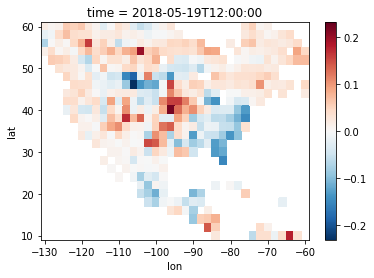

In [10]:
# Run the node (on AWS Lambda) and get the results back
# (the first time this runs will be slower than subsequent calls)
output = node.eval(coords)
output.plot()
pass

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
D:\podpac-2.2.0\miniconda\envs\podpac\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


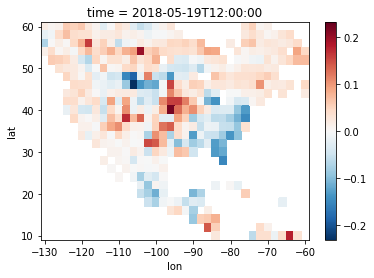

In [11]:
o = diff.eval(coords)
o.plot()
pass